In [1]:
%pylab inline
mpl.rcParams['figure.figsize'] = [12,8]
import graph_tool.all as gt
from joblib import Parallel, delayed, cpu_count
import scipy
import scipy.optimize
import scipy.special
import time
from braids import *        # All the good stuff is in braids.py

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Create a random braid with a 25 node network, and a probability that any given node will produce a block in a given `tick` of $$\frac{2^{246}}{2^{256}-1} \simeq 0.1\%.$$
With 25 nodes this means that each "tick" there is a $\sim 2.4\%$ chance that the network will generate a new bead.  This is small, and the resulting graph is close to a blockchain.

The network has a random topology of nodes, distributed on the surface of a sphere.  Each node is connected to 4 other nodes, with a latency given by their arc distance on the sphere.  A network with a low target (high dificulty) is blockchain-like, with an occasional diamond in it, which Bitcoin would orphan.  `TICKSIZE=0.1` so time is incremented by a tenth of a second with each iteration, and beads are propagated to connected nodes and delivered after a time interval given by their latency.

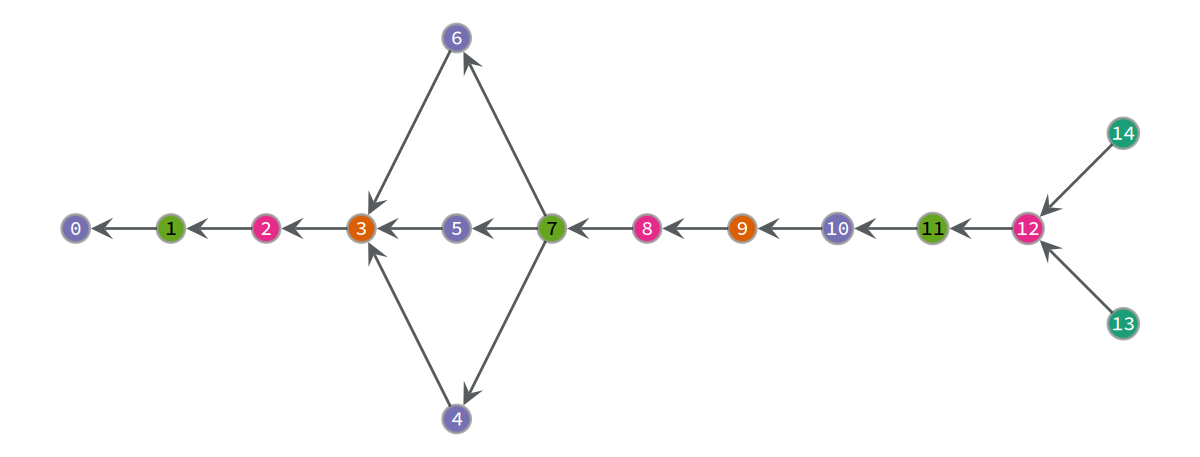

In [2]:
try: del n                         # this is here so that if you re-execute this block, it will create a new network
except: pass
n = Network(25, target=2**246)     # A smaller network or lower target makes thinner braids
for dummy in range(500): n.tick(mine=False)
b = n.nodes[0].braids[0]
b.plot(numbervertices=True);

Keeping the same network `n`, let's increase the target (decrease the difficulty) to produce a thicker braid.  Also, this time let's actually mine, to see that the graphs are the same.  The number of iterations until this node mines a bead is given by the [geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution).  This may give a computational speedup for graphing under the right circumstances.  (It's no speedup with this example)

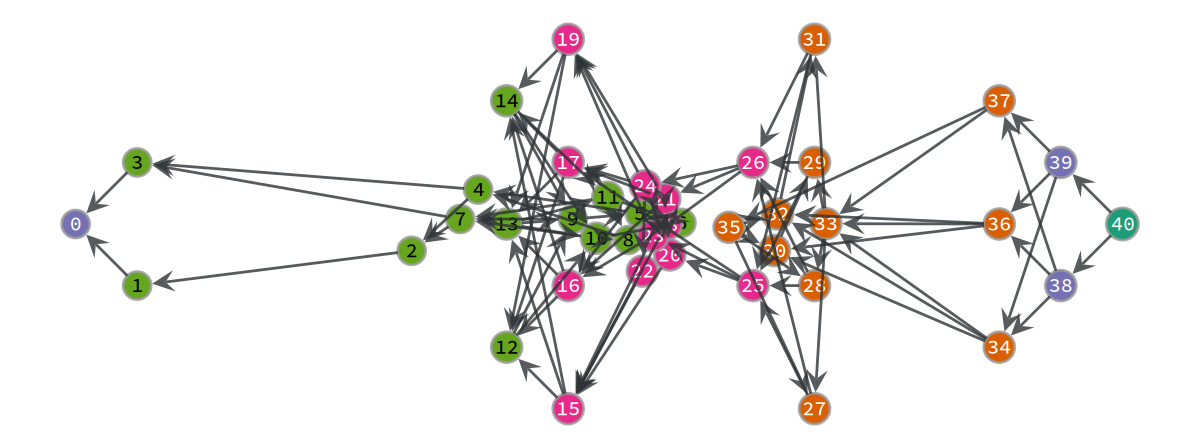

In [3]:
n.reset(target=2**249)
for dummy in range(200): n.tick(mine=True)
b = n.nodes[0].braids[0]
b.plot(numbervertices=True);

Let's turn to how to evaluate a rewards algorithm on a network.  Let's choose one bead to focus on and examine its sibling structure. Siblings are beads in the same cohort that cannot be decided to come before or after one another, since the network is asychronous (they were mined by miners on opposite sides of the planet at nearly the same time).  These might contain the same transaction.  

Siblings are labeled by the number of beads in the (ancestor, descendant) direction (called "rank") one must travel **from the sibling** to find a common ancestor.  The black-circled bead is the one under consideratoin, and its siblings are labeled by their rank (m,n).

This quantity, or something similar, might be used in evaluating rewards for miners.  It gives a measure based on graph structure alone of which beads might have been withheld.

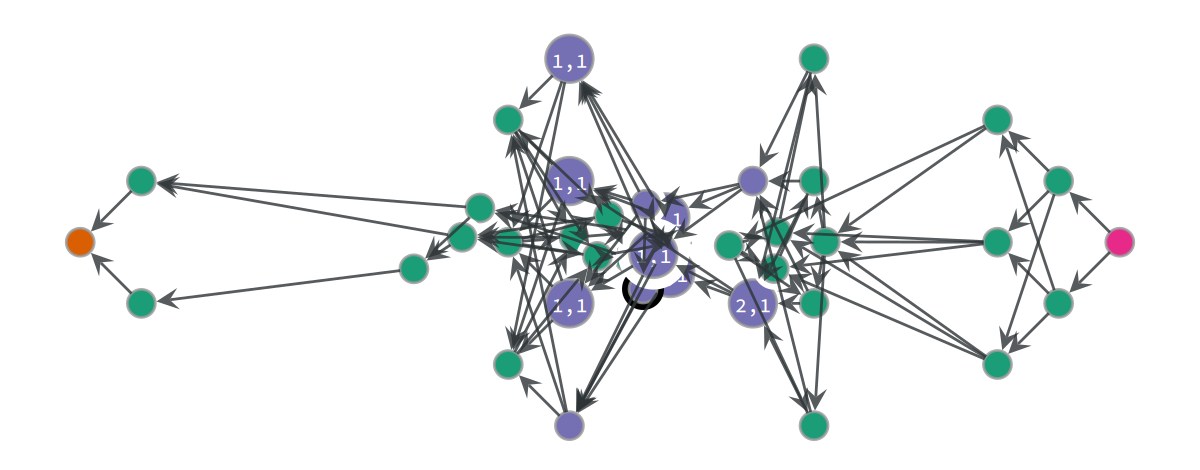

In [4]:
b.plot(focusbead=b.vertex(b.num_vertices()/2+2));

Now let's play with the reward model.  (Modify `Braid.rewards(...)` to try a different model)

If we assume a fixed reward per cohort, and that within the cohort we distribute rewards proportionally, we end up with a graph like the following. (Note that this is not a very good reward model)  The *area* of each cohort is equal, if you sum the areas of the constituent beads.  Area proportionality is done purely for an intuitive visual representation.

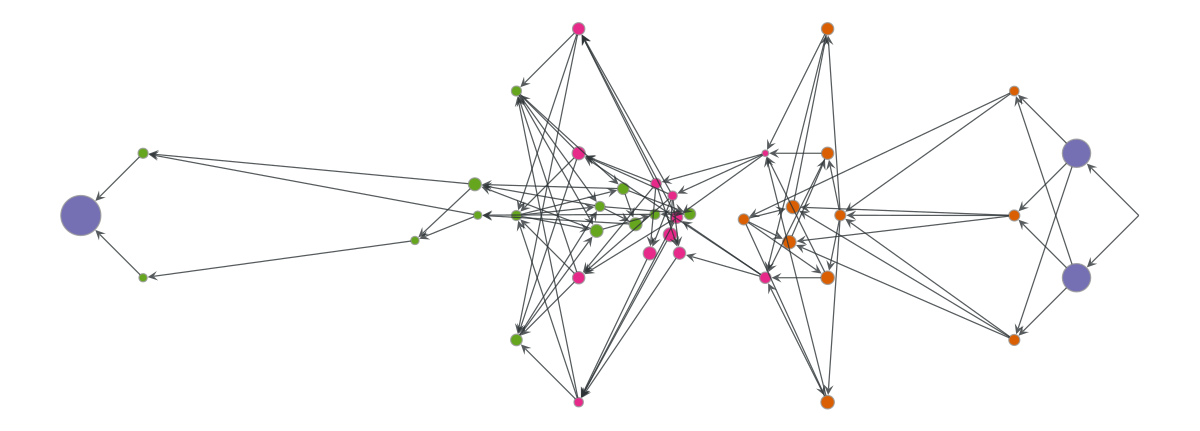

In [5]:
b.plot(rewards=True, K=1.8);

Now let us examine the behavior of cohorts as we vary the target difficulty.

This can be fairly time consuming.  We're essentially going to simulate an entire network with 25 nodes for many millions of beads, in order to get enough resolution on the graph.  We use `joblib` to parallelize creation of the following graphs using a map/reduce algorithm.  Each job will create `ncohorts/cpu_count` cohorts.

The relative vertical error in this graph is $\frac{1}{\sqrt{N}}$ with $N$ cohorts as data points, so for a very smooth graph with error ~1% we need $N=10000$.  This takes a couple days on a beefy computer.  Instead let's just do $N=100$.  The resulting curve will be noisy but it's enough to extract the salient parts.  Determining the cohorts is roughly $\mathcal{O}(B_C^2)$ in the number of beads per cohort $B_C$, so we will stop adding data points when the computation time rises for large $B_C$.

Go get a coffee now...this takes a few minutes.

In [6]:
dctimes = [] # Initialize our results

In [7]:
def job(n, difficulty, ncohorts, njob):
    begin = time.process_time()
    np.random.seed((int(time.time())*njob)%(2**32-1))# We have to seed the random number generator with something
    n.reset(target=difficulty*(1<<255))              # different for each job or they will all generate exactly 
    times = []                                       # the same results!
    lastcohort = frozenset({n.nodes[0].braids[0].vertex(0)})
    while len(list(n.nodes[0].braids[0].cohorts())) < ncohorts:  # 1% error = sqrt(N)/N
        for dummy in range(100): n.tick()
        for c in n.nodes[0].braids[0].cohorts(lastcohort): pass
        lastcohort = c
    b = n.nodes[0].braids[0]
    times.append(b.cohort_time())
    #print(difficulty, times, b.ncohorts)
    return((difficulty,numpy.mean([m for (m,s) in times]), len(b.beads), b.ncohorts, time.process_time()-begin))

def parmap(f, *args):
    """ Map the function f with arguments <args>, adding an extra argument which is its job number. """
    return Parallel(n_jobs=cpu_count())(delayed(f)(*args, job) for job in range(cpu_count()))

def gettimes(n, difficulty, ncohorts):
    def reduce(result):    
        return (difficulty, numpy.mean([m[1] for m in result]), sum([m[2] for m in result]), 
                sum([m[3] for m in result]), sum([m[4] for m in result]))
    return reduce(parmap(job, n, difficulty, ncohorts/cpu_count()))

print("(target difficulty,      mean cohort time, nbeads, ncohorts, CPU time)")
for difficulty in exp(arange(-8.5, -3.375, 0.0625)):
    if(any([x[0]==difficulty for x in dctimes])): continue
    dctimes.append(gettimes(n, difficulty, 100))
    print(dctimes[-1], ",")
    if(dctimes[-1][-1] > 5*60): break # If it takes longer than 5 CPU-minutes stop
                                      # re-run this block to add another row to dctimes.

(target difficulty,      mean cohort time, nbeads, ncohorts, CPU time)
(np.float64(0.00020346836901064417), np.float64(40.18478260870026), np.int64(102), np.int64(100), np.float64(19.060365369)) ,
(np.float64(0.00021659095137688503), np.float64(34.41086956522131), np.int64(101), np.int64(100), np.float64(16.385375706000005)) ,
(np.float64(0.00023055986759244163), np.float64(33.65978260869899), np.int64(102), np.int64(100), np.float64(19.104484493)) ,
(np.float64(0.0002454297015009895), np.float64(32.517391304352245), np.int64(102), np.int64(100), np.float64(17.055422149)) ,
(np.float64(0.00026125855730166754), np.float64(30.132925724641584), np.int64(105), np.int64(101), np.float64(15.839150847999996)) ,
(np.float64(0.00027810828659249914), np.float64(26.59239130435089), np.int64(101), np.int64(100), np.float64(14.131572176999995)) ,
(np.float64(0.0002960447300568554), np.float64(28.85629528985872), np.int64(105), np.int64(102), np.float64(15.007579262000007)) ,
(np.float64(0.000315137

This resulting curve (see below) is extremely well approximated by
$$
T(x) = \frac{1}{\lambda x} + a e^{a \lambda x}
$$
where $T(x)=T_C$ is the cohort time as a function of target $x$ and is measured at constant x within a window of time known as the "retarget window".  We assume that an algorithm will select a new target $x^\prime$ based on the data accumulated at $x$.  We assume that $\lambda$ and $a$ are constant over the window, and we measure $T_C, T_B, N_C, N_B$ for the chosen $x$.

The parameters can be understood intuitively, $\frac{1}{\lambda x} = T_B$ is the bead time.  The parameter $a$ has dimensions of time and can be thought of as the "size" of the network -- the amount of time required for a bead to traverse the network.  It is directly related to the orphan or uncle rate, in the blockchain limit, as well as what has been called "miner utilization" by other authors.

The parameter $\lambda$ is the hash rate and can be obtained along with $a$:
$$
\lambda = \frac{N_B}{x T_C N_C}; \qquad a = T_C W\left(\frac{T_C}{T_B} - 1\right)
$$
where $N_B$ is the number of beads and $N_C$ is the number of cohorts.  $W(z)$ is the 
[Lambert W function](https://en.wikipedia.org/wiki/Lambert_W_function).
With these in hand we can compute the location of the minimum
$$
x_0 = \frac{2 W\left(\frac12\right)}{a \lambda} = \frac{0.7035}{a\lambda}
$$
This is independent of network topology.  (See the `topology` parameter of `class Network` -- this graph
is for miners distributed on the surface of a sphere, but setting `topology` to something else generates
a random network)

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_419/837114687.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.loglog(x, f(x, lam, a), label='fit $\lambda=%3.2f$ hashes/s; $a=%1.4f$s'%(lam,a))
/tmp/ipykernel_419/837114687.py:10: SyntaxWarning: invalid escape sequence '\p'
  plt.axvline(x0, label="Fastest cohort time $T_C^\prime=%1.3f$s at target $x_0=%f$"%(f(x0,lam,a),x0), color='red')


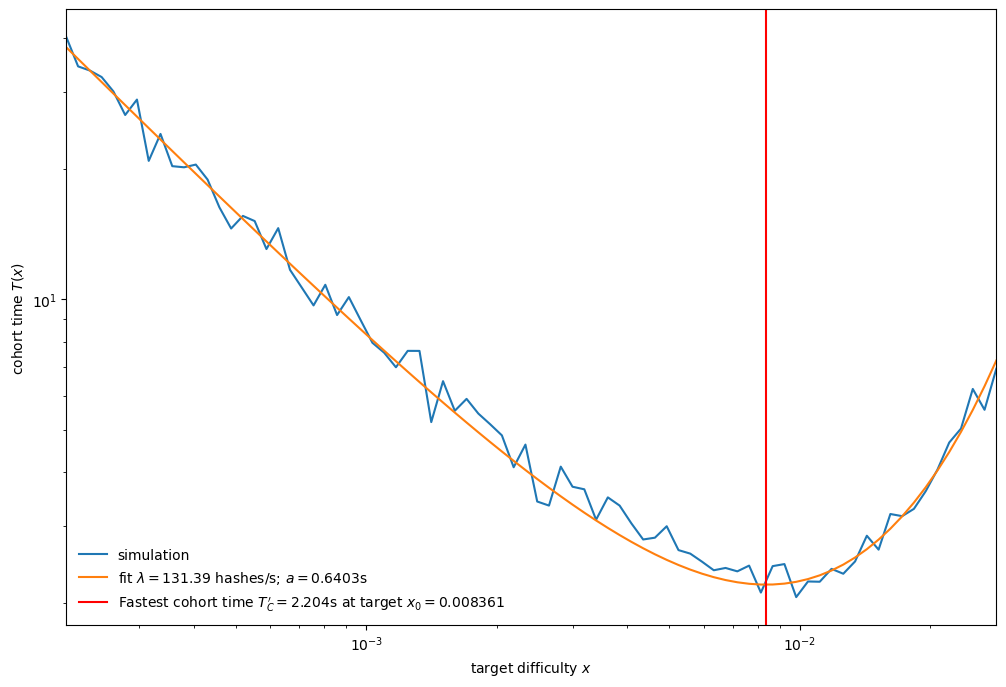

In [8]:
x = np.array([p[0] for p in dctimes])
def f(x,lam,a): return 1/lam/x+a*np.exp(a*lam*x)
y = np.array([p[1] for p in dctimes])
((lam,a),dummy) = scipy.optimize.curve_fit(f, x, y, [100, 1])
plt.loglog(x, y, label='simulation')
plt.loglog(x, f(x, lam, a), label='fit $\lambda=%3.2f$ hashes/s; $a=%1.4f$s'%(lam,a))
plt.xlabel("target difficulty $x$")
plt.ylabel("cohort time $T(x)$")
x0 = numpy.real(2*scipy.special.lambertw(1/2)/a/lam)
plt.axvline(x0, label="Fastest cohort time $T_C^\prime=%1.3f$s at target $x_0=%f$"%(f(x0,lam,a),x0), color='red')
plt.xlim(x[0], x[-1])
plt.legend(loc='lower left', frameon=False);

In the blockchain limit, $x \to 0$, the cohort time is approximately
$$
T(x) = \frac{1}{\lambda x} + a + \mathcal{O}(x)
$$
which allows us to see that the quantity $a$ is the increase in effective block time due to network latency effects.  This is to say that the actual cohort time is slightly longer than expected from the hashrate.

The right side of the above graph can be understood intuitively as well: for large targets (low difficulty) we are producing beads so fast that there is nearly always one in flight.  The only way a cohort can form is when there is accidentally a quiescent period where no miner produces a bead.  The probability of that happening is exponentially suppressed.

The use of a braid allows for a **zero parameter retarget algorithm** which instead of targeting a fixed block time, targets the fastest possible block time.  Evaluating the above for the Bitcoin network, which has had an orphan rate of 1.16 orphans/day on average over the last 2 years with a block time of $600$s, we find that $a=4.79$s and the cohort time at the minimum is $11.64$s.

It should be noted that even if a coin desires to have a fixed-block time for other reasons, it is still desirable to allow the merging of blocks, whether they would be orphans, or are due to a network split.  The above analysis still applies to such a scenario.  The extra blocks are called "orphans" or "uncles" in those scenarios.